Modeling an autoregressive process 

In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\user\Downloads\foot_traffic.csv")

df.head()


,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


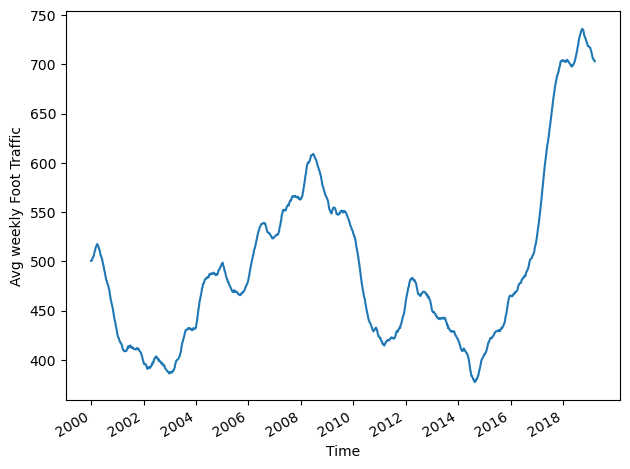

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Avg weekly Foot Traffic')

plt.xticks(np.arange(0,1000,104), np.arange(2000,2020,2))

fig.autofmt_xdate()
plt.tight_layout()


> No cyclic pattern thus rule out seasonality

> Check for stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -1.1758885999240742
p-value: 0.6838808917896192


P-value greater than 0.05 and ADF value is not a large negative number, the hypothesis cannot be rejected, thus our series is non stationary

> Apply transformation - use differencing to remove the trend and stabilize the mean of the series. 

In [5]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

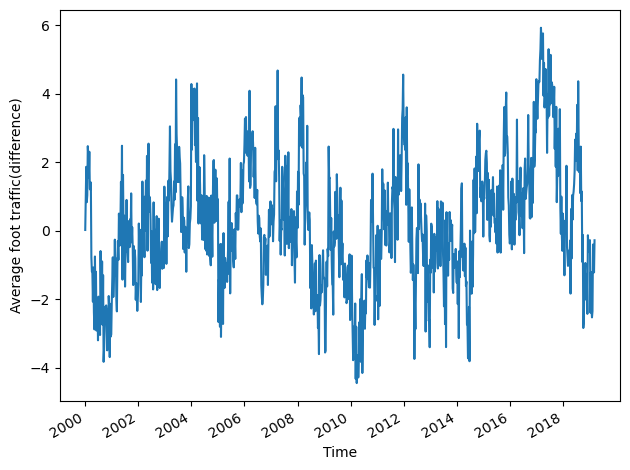

In [6]:
fig, ax =plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average foot traffic(difference)')

plt.xticks(np.arange(0,1000,104), np.arange(2000,2020,2))

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
#verify whether the series is stationary 

adf_result = adfuller(foot_traffic_diff)

print(f'ADF statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF statistic: -5.268231347422029
p-value: 6.369317654781772e-06


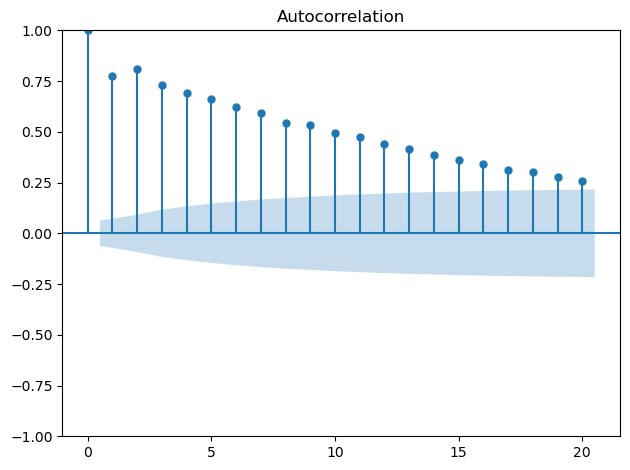

In [8]:
#plot acf and find out autocorrelation and coefficients

from statsmodels.graphics.tsaplots import plot_acf 

plot_acf(foot_traffic_diff, lags=20)

plt.tight_layout()

plt.show()

>   There is no lag at which the coefficients abruptly become non-significant 

>   Beyond lag 0, we have significant autocorrelation coefficients beyond lag 0. We see a pattern of exponential decay 

>   Plot a partial autocorrelation function plot. 

In [11]:
from statsmodels.tsa.arima_process import ArmaProcess 

np.random.seed(42)

ma2 = np.array([1,0,0]) #coefficients of MA process are set to 0 bc we only want to simulate AR process, the first coeffcient is 1 for lag 0

ar2 = np.array([1, -0.33, -0.50]) #coefficient of lag 0 is 1. We write the coefficients with opposite signs to those we wish to simulate. 

AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)


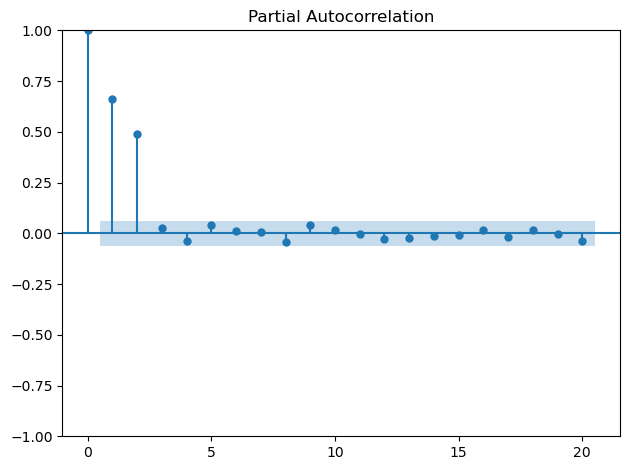

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20)

plt.tight_layout()

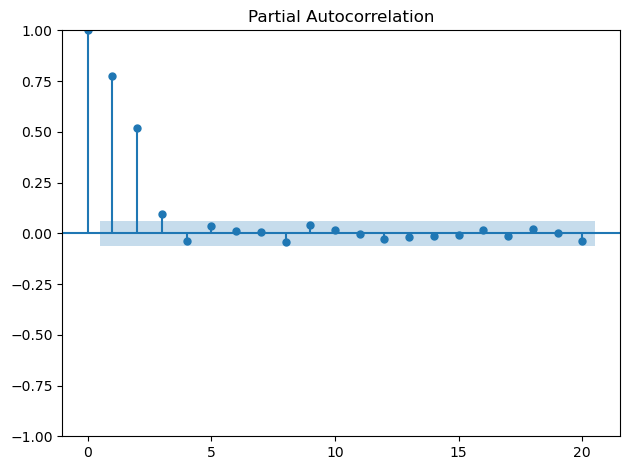

In [13]:
plot_pacf(foot_traffic_diff, lags=20)

plt.tight_layout()

No significant coefficients observed after lag 3, thus we have an order of 3 in our AR process

Forecasting an Autoregressive Process 

In [15]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

train = df_diff[:-52] #all data except the last 52 data points 
test = df_diff[-52:] #test set is the last 52 data points

print(len(train))
print(len(test))

947
52


Applying differencing gets us one less data point in our new series compared to our original 

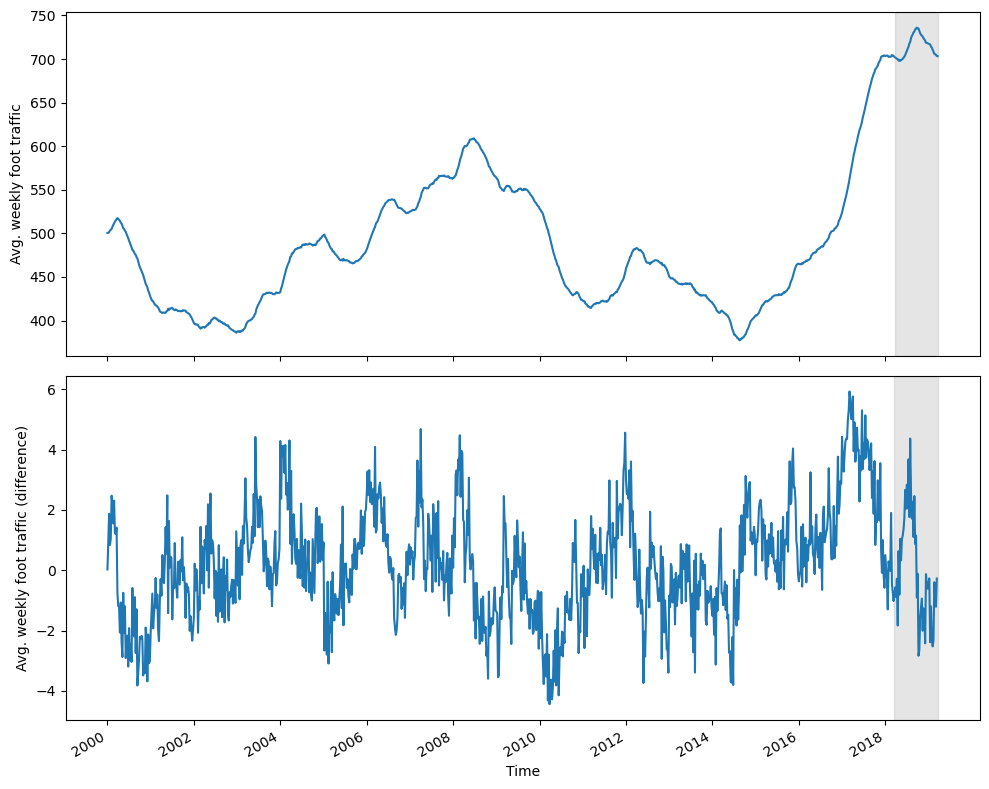

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color = 'grey', alpha = 0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Avg. weekly foot traffic (difference)')
ax2.axvspan(947, 999, color='grey', alpha=0.2)

plt.xticks(np.arange(0,1000,104), np.arange(2000,2020,2))

fig.autofmt_xdate()
plt.tight_layout()

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def rolling_forecast(df: pd.DataFrame, train_len: int, horizon:int,window:int, method:str) ->list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range (train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    
    elif method =='last':
        pred_last_value = []

        for i in range (train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range (window))

        return pred_last_value

    elif method =='AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        return pred_AR 


In [20]:
#our window is 1 since we wish to predict the next timestep 

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean']= pred_mean
test['pred_last_value']= pred_last_value
test['pred_AR'] = pred_AR 

test.head()


C:\Users\user\AppData\Local\Temp\ipykernel_29212\2718275368.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean']= pred_mean
C:\Users\user\AppData\Local\Temp\ipykernel_29212\2718275368.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last_value']= pred_last_value
C:\Users\user\AppData\Local\Temp\ipykernel_29212\2718275368.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


Visualize our predictions from the differenced series 

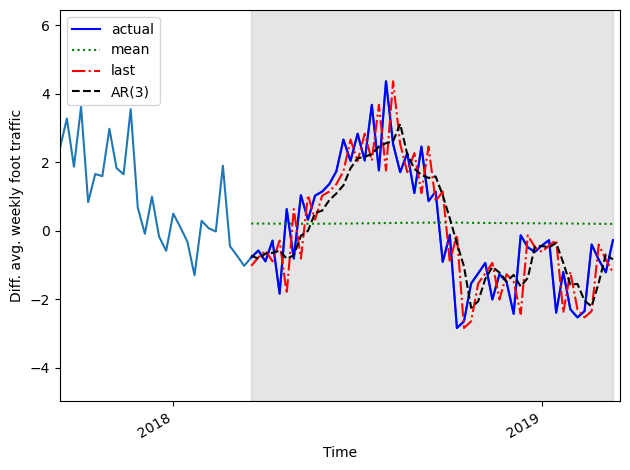

In [21]:
fig, ax = plt.subplots()

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='grey', alpha=0.2)

ax.set_xlim(920,999)
plt.xticks([936, 988], [2018,2019])

fig.autofmt_xdate()
plt.tight_layout()



using the historical mean produces a straight line, which is shown in the plot as a dotted line. As for the predictions from the AR(3) model and the last known value method, the curves are almost confounding
with that of the test set, so we will have to measure the MSE to assess which method is the most performant.

In [22]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.9242479164603883


The AR(3) model is the best performing method, with the lowest MSE. Modeling using this model will yield the best predictions.  

Since our forecasts are differenced values, we need to reverse the transformation in order to bring our forecasts back to the original scale of the data; otherwise, our predictions will not make sense in a business context.

Take the cumulative sum of our predictions and add it to the last value of our training set in the
original series. This point occurs at index 948, since we are forecasting the last 52 weeks in a dataset containing 1,000 points.

In [24]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

C:\Users\user\AppData\Local\Temp\ipykernel_29212\3875516694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()


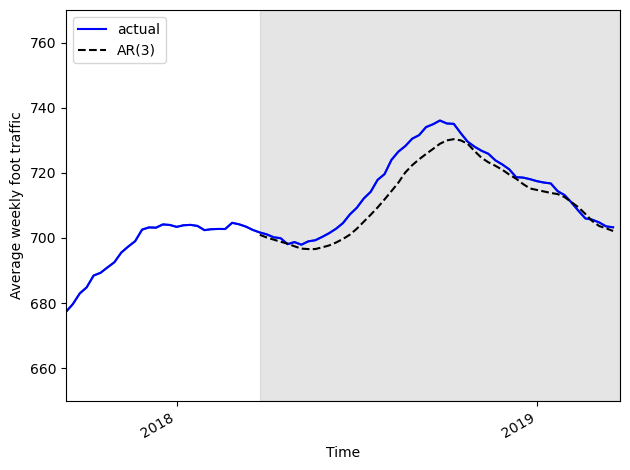

In [25]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

Measure the MAE on the original dataset 

In [26]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print(mae_AR_undiff)

3.4780335553330417


This means that our predictions are off by 3.45 people on average, either above or below the actual value for the week’s foot traffic. We report the MAE because it has a simple business meaning that is easy to understand and interpret.